Решить задачу регрессии.
Получить максимальную метрику качества (R2, RMSE).

Введение<br>
Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv
- Использовать пайплайны.
- Выполнить поиск лучших параметров / *hyperopt / **optuna
- Кроссвалидация / различные типы проверок.
- Сохранить и загрузить модель. 
- H20 (если получиться)
- +phik

In [1]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

from phik.report import plot_correlation_matrix

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import optuna
import pickle
import h2o


In [2]:
# read DataFrame
excel_path = 'Walmart.csv'
sales_df = pd.read_csv(excel_path)

sales_df


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [4]:
sales_df.describe()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [4]:
sales_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
# find NaN values in table
sales_df.isna().any()


Store           False
Date            False
Weekly_Sales    False
Holiday_Flag    False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
dtype: bool

In [3]:
# set target column name
TARGET = 'Weekly_Sales'


In [4]:
# split dataset into train and test 
train_df, test_df = train_test_split(sales_df, test_size=0.2)

TRAIN_IDXS = train_df.index
TEST_IDXS = test_df.index


Как видно из выводов выше, столбец с датой является строковым и требует предобработки. Разделим столбец с датой на столбцы с днем, годом и месяцем, добавим в таблицу. <br>
Пропуски в столбцах таблицы отсутствуют, заполнять ничего не нужно.<br>
Проведем нормализацию значений в столбцах при помощи MinMaxScaler.

In [5]:
# create custom class for split column Date in DataFrame to columns Year, Month, Day
class CustomProcessor(BaseEstimator, TransformerMixin): 
   def __init__(self): 
      pass
   
   def fit(self, X, y=None): 
      return self

   # split Date to Year, Month, Day columns
   def transform(self, X: pd.DataFrame, y=None): 
      res_x = X.copy()

      if 'Date' in res_x.columns:
         res_x['Date'] = pd.to_datetime(res_x['Date'], format='%d-%m-%Y')

         res_x['Day'] = res_x['Date'].dt.day
         res_x['Month'] = res_x['Date'].dt.month
         res_x['Year'] = res_x['Date'].dt.year

         res_x.drop(columns=['Date'], inplace=True)
      return res_x


Находим лучшие гиперпораметры для DecisionTreeRegressor при помощи модуля optuna, рассчитываем метрики r2 и RMSE для модели с лучшими параметрами, анализируем важность признаков.

In [6]:
optuna.logging.set_verbosity(optuna.logging.ERROR)


In [7]:
# create custom function to choose best params for DecisionTreeRegressor
def get_best_model(df: pd.DataFrame):
    # get features columns
    features = df.columns.tolist()

    if TARGET in features:
        features.remove(TARGET)
    print('Features for training:', features)

    # get train and test dataset parts 
    train_df = df.iloc[TRAIN_IDXS]
    test_df = df.iloc[TEST_IDXS]

    def objective(trial):
        criterion_name = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])
        splitter_name = trial.suggest_categorical('splitter', ['best', 'random'])
        min_samples_split_num = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf_num = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features_name = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

        regression_pipe = Pipeline(steps=[('processor', CustomProcessor()),
                                          ('transformer', MinMaxScaler()), 
                                          ('regressor', DecisionTreeRegressor(criterion=criterion_name, 
                                                                              splitter=splitter_name,
                                                                              min_samples_split=min_samples_split_num,
                                                                              min_samples_leaf=min_samples_leaf_num,
                                                                              max_features=max_features_name,
                                                                              random_state=0))])

        scores = cross_validate(regression_pipe, train_df[features], train_df[TARGET], 
                                scoring=('r2', 'neg_root_mean_squared_error'), return_train_score=True, 
                                n_jobs=-1)

        return np.mean(scores['test_r2'])

    # create optuna object to maximize r2 score of Pipeline regressor, find the most optimal params
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000, n_jobs=-1)

    # get DecisionTreeRegressor best params
    print(F'\nBest trial #{study.best_trial.number}, r2 value - {study.best_value}')
    print('Best params:')
    print(study.best_params)

    # create Pipeline with best parameters and fit
    pipe_model = Pipeline(steps=[('processor', CustomProcessor()),
                                 ('transformer', MinMaxScaler()), 
                                 ('regressor', DecisionTreeRegressor(**study.best_params, random_state=0))])

    pipe_model = pipe_model.fit(train_df[features], train_df[TARGET])
    scores = cross_validate(pipe_model, train_df[features], train_df[TARGET], 
                            scoring=('r2', 'neg_root_mean_squared_error'), return_train_score=True, 
                            n_jobs=-1)

    print('\nAverage validation r2-score:', np.mean(scores['test_r2']))
    print('Average validation Root Mean Squared Error:', np.mean(scores['test_neg_root_mean_squared_error']))

    y_pred = pipe_model.predict(test_df[features])
    R2 = r2_score(test_df[TARGET], y_pred)
    RMSE = root_mean_squared_error(test_df[TARGET], y_pred)

    print('\nTest r2-score:', R2)
    print('Test Root Mean Squared Error:', RMSE)

    return pipe_model


In [8]:
pipe_model = get_best_model(sales_df)


Features for training: ['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']



Best trial #340, r2 value - 0.9448992097938692
Best params:
{'criterion': 'poisson', 'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}

Average validation r2-score: 0.9448992097938692
Average validation Root Mean Squared Error: -132437.86368560218

Test r2-score: 0.9434364078683538
Test Root Mean Squared Error: 133371.68000306463


Выше получена точность лучшей модели на обучающей и тестовой выборках. Проаналиизируем корреляцию признаков.  

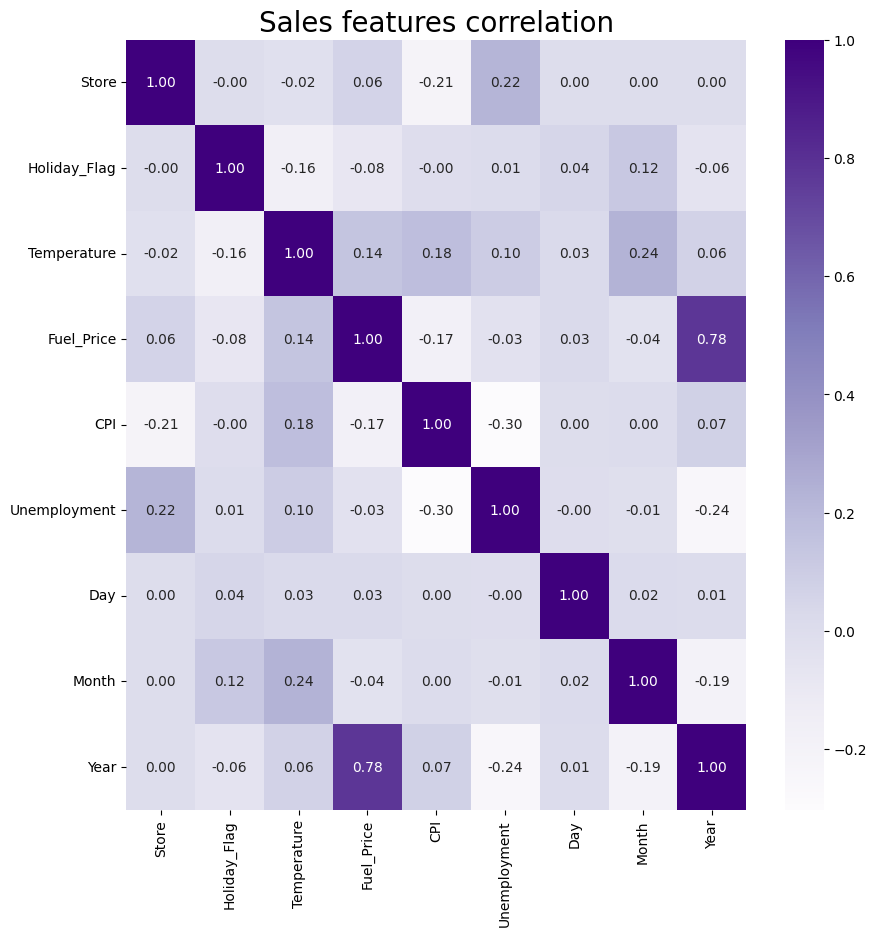

In [9]:
# show correlation heatmap
sales_features = sales_df.columns.tolist()
if TARGET in sales_features:
    sales_features.remove(TARGET)

transformed_df = pipe_model['processor'].fit_transform(sales_df[sales_features])
correlation_df = transformed_df.corr()
transformed_df = pd.concat([transformed_df, sales_df[TARGET]], axis=1)

plt.figure(figsize=(10, 10))
sb.heatmap(correlation_df, xticklabels=correlation_df.columns, yticklabels=correlation_df.columns, annot=True, 
           fmt='.2f', cmap="Purples")

plt.title('Sales features correlation', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


Из карты корреляции видно, что стоимость топлива Fuel_Price прямопропорционально связана с годом Year, поэтому объединим их в один столбец перемножив данные.

In [10]:
transformed_df['Fuel_Price_per_Year'] = transformed_df['Fuel_Price'] * transformed_df['Year']
transformed_df.drop(columns=['Fuel_Price', 'Year'], inplace=True)
transformed_df


,Store,Holiday_Flag,Temperature,CPI,Unemployment,Day,Month,Weekly_Sales,Fuel_Price_per_Year
0,1,0,42.31,211.096358,8.106,5,2,1643690.90,5169.720
1,1,1,38.51,211.242170,8.106,12,2,1641957.44,5121.480
2,1,0,39.93,211.289143,8.106,19,2,1611968.17,5053.140
3,1,0,46.63,211.319643,8.106,26,2,1409727.59,5147.610
4,1,0,46.50,211.350143,8.106,5,3,1554806.68,5276.250
...,...,...,...,...,...,...,...,...,...
6430,45,0,64.88,192.013558,8.684,28,9,713173.95,8041.964
6431,45,0,64.89,192.170412,8.667,5,10,733455.07,8017.820
6432,45,0,54.47,192.327265,8.667,12,10,734464.36,8048.000
6433,45,0,56.47,192.330854,8.667,19,10,718125.53,7985.628


In [11]:
pipe_model_transformed = get_best_model(transformed_df)


Features for training: ['Store', 'Holiday_Flag', 'Temperature', 'CPI', 'Unemployment', 'Day', 'Month', 'Fuel_Price_per_Year']

Best trial #157, r2 value - 0.940914090781636
Best params:
{'criterion': 'squared_error', 'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}

Average validation r2-score: 0.940914090781636
Average validation Root Mean Squared Error: -137066.3567062533

Test r2-score: 0.943956994929463
Test Root Mean Squared Error: 132756.5134062852


После объединения столбцов точность на тестовой выборке не сильно повысилась. <br>
Проанализируем важность признаков. Выберем наиболее значимые признаки и построим модель на них.

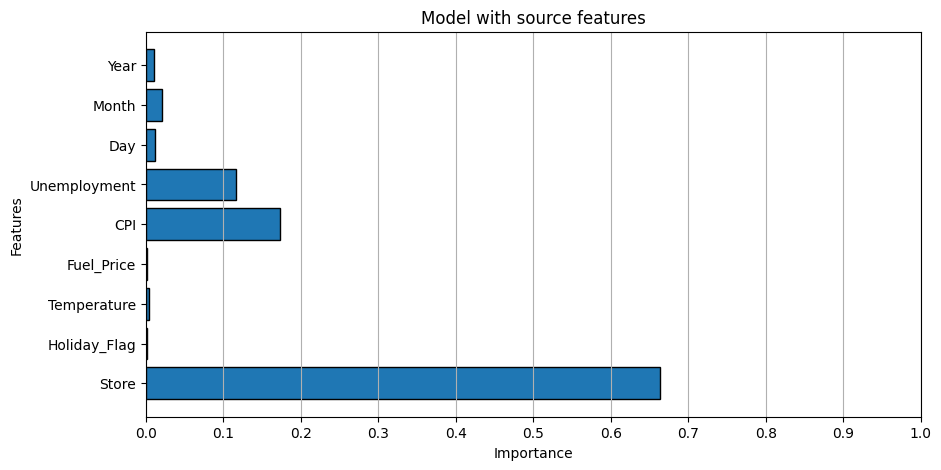

In [12]:
# visualize features importance
plt.figure(figsize=(10, 5))

plt.barh(y=pipe_model['transformer'].get_feature_names_out(), width=pipe_model['regressor'].feature_importances_, edgecolor='k')
plt.title('Model with source features')

plt.xlim(0., 1.)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.1))
plt.grid(axis='x')


In [13]:
# get the most important features
IMPORTANCE_TH = 0.02

important_features = set()
for name, importance in zip(pipe_model['transformer'].get_feature_names_out(), pipe_model['regressor'].feature_importances_):
    if importance >= IMPORTANCE_TH:
        if name in ['Day', 'Month', 'Year']:
            important_features.add('Date')
        else:
            important_features.add(name)

important_features = list(important_features)
truncated_df = sales_df[important_features + [TARGET]].copy()
important_features


['Store', 'Date', 'Unemployment', 'CPI']

In [14]:
pipe_model_truncated = get_best_model(truncated_df)


Features for training: ['Store', 'Date', 'Unemployment', 'CPI']



Best trial #904, r2 value - 0.9496765486353173
Best params:
{'criterion': 'squared_error', 'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}

Average validation r2-score: 0.9496765486353173
Average validation Root Mean Squared Error: -126367.78282699043

Test r2-score: 0.9474880824094071
Test Root Mean Squared Error: 128506.19651197523


После выбора наиболее значимых столбцов точность на тестовой выборке незначительно повысилась. Сохраним эту модель в формате .pkl. т. к. ее метрики лучше.<br>

In [22]:
model_name = 'truncated_sale_model.pkl'

# save model to file
with open(model_name, 'wb') as model_file:
    pickle.dump(pipe_model_truncated, model_file)


In [23]:
# load model from file
with open(model_name, 'rb') as model_file:
    pipe_model_loaded = pickle.load(model_file)


In [24]:
# get predict from loaded model
test_df = truncated_df.iloc[TEST_IDXS]
y_pred = pipe_model_loaded.predict(test_df[important_features])
R2 = r2_score(test_df[TARGET], y_pred)
RMSE = root_mean_squared_error(test_df[TARGET], y_pred)

print('Test r2-score:', R2)
print('Test Root Mean Squared Error:', RMSE)


Test r2-score: 0.9474880824094071
Test Root Mean Squared Error: 128506.19651197523


Теперь испольуем phik для вычисления корреляции между принаками набора данных.

In [18]:
# create correlation matrix with phik
phik_correlation = sales_df[sales_features].phik_matrix()
phik_correlation


interval columns not set, guessing: ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000,0.000000,0.000000,0.376575,0.325780,0.578986,0.689064
Date,0.000000,1.000000,1.000000,0.748962,0.865696,0.444183,0.362597
Holiday_Flag,0.000000,1.000000,1.000000,0.235493,0.169441,0.000000,0.000000
Temperature,0.376575,0.748962,0.235493,1.000000,0.495514,0.335435,0.287975
Fuel_Price,0.325780,0.865696,0.169441,0.495514,1.000000,0.493494,0.511182
CPI,0.578986,0.444183,0.000000,0.335435,0.493494,1.000000,0.552244
Unemployment,0.689064,0.362597,0.000000,0.287975,0.511182,0.552244,1.000000


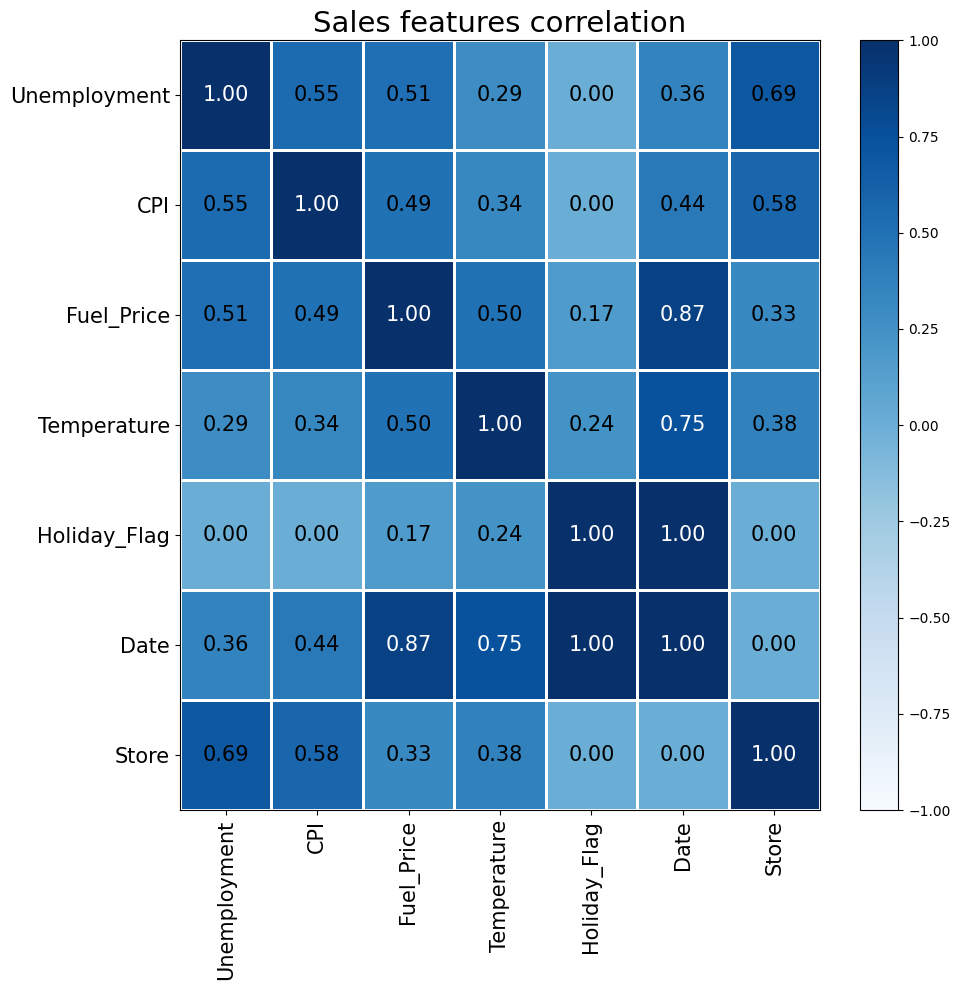

In [19]:
# draw correlation matrix
plot_correlation_matrix(phik_correlation.values, x_labels=phik_correlation.columns, y_labels=phik_correlation.index, 
                        color_map='Blues', title='Sales features correlation', fontsize_factor=1.5, figsize=(10, 10))
plt.tight_layout()


Как видно из корреляционной карты, есть зависимость между датой Date и праздничным днем Holiday_Flag, датой Date и температурой Temperature, датой Date и стоимостью топлива Fuel_Price. А также между магазином Store и безработицей Unemployment, магазином Store и индексом потребительских цен CPI. <br>
Удалим колонки Holiday_Flag, Temperature, Fuel_Price и Unemployment, т. к. их можно описать признаками из колонок Date и Store. Также, в этот раз не будем разбивать дату на три колонки, а заменим числовыми метками с помощью LabelEncoder.

In [20]:
cropped_df = sales_df[['Date', 'Store', 'CPI'] + [TARGET]].copy()

encoder = LabelEncoder()
cropped_df['Date_num'] = encoder.fit_transform(cropped_df['Date'])
cropped_df.drop(columns=['Date'], inplace=True)

pipe_model_cropped = get_best_model(cropped_df)


Features for training: ['Store', 'CPI', 'Date_num']

Best trial #177, r2 value - 0.9174646696090264
Best params:
{'criterion': 'absolute_error', 'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None}

Average validation r2-score: 0.9174646696090264
Average validation Root Mean Squared Error: -159866.9503777033

Test r2-score: 0.9225505776417723
Test Root Mean Squared Error: 162638.8020510634


Как видно по метрикам, точность модели в сравнении с лучшим результатом заметно упала из-за кодирования даты и такого сокращения количества признаков.<br>
Можно обратить внимание, что столбцы Holiday_Flag, Temperature и Fuel_Price, которые имели маленький процент значимости данных для модели, при построении корреляции с phik также оказались коррелирующими с другими столбцами и не несущими разнообразной информации.

In [24]:
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /media/vik/fleshechka2-ntfs/pyvenv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5fxyjopx
  JVM stdout: /tmp/tmp5fxyjopx/h2o_vik_started_from_python.out
  JVM stderr: /tmp/tmp5fxyjopx/h2o_vik_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,23 secs
H2O_cluster_timezone:,Europe/Minsk
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 3 days
H2O_cluster_name:,H2O_from_python_vik_keocwi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.418 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [83]:
sales_h2o = h2o.import_file(excel_path)
sales_h2o


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1,05-02-2010,1.64369e+06,0,42.31,2.572,211.096,8.106
1,12-02-2010,1.64196e+06,1,38.51,2.548,211.242,8.106
1,19-02-2010,1.61197e+06,0,39.93,2.514,211.289,8.106
1,26-02-2010,1.40973e+06,0,46.63,2.561,211.32,8.106
1,05-03-2010,1.55481e+06,0,46.5,2.625,211.35,8.106
1,12-03-2010,1.43954e+06,0,57.79,2.667,211.381,8.106
1,19-03-2010,1.47252e+06,0,54.58,2.72,211.216,8.106
1,26-03-2010,1.40443e+06,0,51.45,2.732,211.018,8.106
1,02-04-2010,1.59497e+06,0,62.27,2.719,210.82,7.808
1,09-04-2010,1.54542e+06,0,65.86,2.77,210.623,7.808


In [84]:
sales_h2o['Date'] = sales_h2o['Date'].as_date('%d-%m-%Y')

day_h2o = sales_h2o['Date'].day()
month_h2o = sales_h2o['Date'].month()
year_h2o = sales_h2o['Date'].year()

sales_h2o = sales_h2o.cbind(day_h2o)
sales_h2o = sales_h2o.cbind(month_h2o)
sales_h2o = sales_h2o.cbind(year_h2o)

sales_h2o = sales_h2o.set_names(sales_h2o.columns[:-3] + ['Day', 'Month', 'Year'])
sales_h2o = sales_h2o.drop(['Date'])
sales_h2o


Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
1,1.64369e+06,0,42.31,2.572,211.096,8.106,5,2,2010
1,1.64196e+06,1,38.51,2.548,211.242,8.106,12,2,2010
1,1.61197e+06,0,39.93,2.514,211.289,8.106,19,2,2010
1,1.40973e+06,0,46.63,2.561,211.32,8.106,26,2,2010
1,1.55481e+06,0,46.5,2.625,211.35,8.106,5,3,2010
1,1.43954e+06,0,57.79,2.667,211.381,8.106,12,3,2010
1,1.47252e+06,0,54.58,2.72,211.216,8.106,19,3,2010
1,1.40443e+06,0,51.45,2.732,211.018,8.106,26,3,2010
1,1.59497e+06,0,62.27,2.719,210.82,7.808,2,4,2010
1,1.54542e+06,0,65.86,2.77,210.623,7.808,9,4,2010


In [85]:
# normalize H2O dataset
for column in sales_h2o.columns:
    if column == TARGET:
        continue

    min_val = sales_h2o[column].min()
    max_val = sales_h2o[column].max()

    if min_val >= 0 and max_val <= 1:
        continue

    sales_h2o[column] = sales_h2o[column].apply(lambda x: (x - min_val) / (max_val - min_val))

sales_h2o


Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1.64369e+06,0,0.434149,0.0501002,0.8405,0.405118,0.133333,0.0909091,0
0,1.64196e+06,1,0.396967,0.0380762,0.841941,0.405118,0.366667,0.0909091,0
0,1.61197e+06,0,0.410861,0.0210421,0.842405,0.405118,0.6,0.0909091,0
0,1.40973e+06,0,0.476419,0.0445892,0.842707,0.405118,0.833333,0.0909091,0
0,1.55481e+06,0,0.475147,0.0766533,0.843008,0.405118,0.133333,0.181818,0
0,1.43954e+06,0,0.585616,0.0976954,0.84331,0.405118,0.366667,0.181818,0
0,1.47252e+06,0,0.554207,0.124248,0.841679,0.405118,0.6,0.181818,0
0,1.40443e+06,0,0.523581,0.130261,0.839726,0.405118,0.833333,0.181818,0
0,1.59497e+06,0,0.629452,0.123747,0.837773,0.376557,0.0333333,0.272727,0
0,1.54542e+06,0,0.664579,0.149299,0.835819,0.376557,0.266667,0.272727,0


In [68]:
TRAIN_IDXS = TRAIN_IDXS.tolist()
TRAIN_IDXS.sort()

TEST_IDXS = TEST_IDXS.tolist()
TEST_IDXS.sort()


In [91]:
# create custom function to choose best params for DecisionTreeRegressor
def get_best_model_h2o(h2o_frame):
    # get features columns
    features = h2o_frame.columns

    if TARGET in features:
        features.remove(TARGET)
    print('Features for training:', features)

    # split dataset into train and test 
    train_val_set = sales_h2o[TRAIN_IDXS, :]
    test_set = sales_h2o[TEST_IDXS, :]
    train_set, val_set = train_val_set.split_frame(ratios=[0.8], seed=1)

    hyper_params = {'ntrees': list(range(50, 501, 50)),
                    'max_depth': list(range(5, 10))}

    grid_h2o = H2OGridSearch(model=H2OGradientBoostingEstimator(stopping_metric='rmse'), 
                             grid_id='grid1', hyper_params=hyper_params)
    grid_h2o.train(x=features, y=[TARGET], training_frame=train_set, validation_frame=val_set)

    metrics_grid = grid_h2o.get_grid(sort_by='rmse', decreasing=False)
    best_model = metrics_grid.models[0]
    test_performance = best_model.model_performance(test_set)
    print(test_performance)

    return best_model


In [92]:
best_model = get_best_model_h2o(sales_h2o)


Features for training: ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Day', 'Month', 'Year']
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 1427282513738.6277
RMSE: 1194689.2959002468
MAE: 1041994.0873396083
RMSLE: 13.49627012425297
Mean Residual Deviance: 1427282513738.6277


In [93]:
saved_path = h2o.save_model(model=best_model, path='h2o_model', force=True)
print('Save model to', saved_path)


Save model to /media/vik/fleshechka2-ntfs/peleng-courses/ML01_P_Online/Viktoria_Olegovna/HW_16/h2o_model/grid1_model_15


In [94]:
load_model = h2o.load_model(path=saved_path)


In [95]:
test_set = sales_h2o[TEST_IDXS, :]

performance = load_model.model_performance(test_set)
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 1427282513738.6277
RMSE: 1194689.2959002468
MAE: 1041994.0873396083
RMSLE: 13.49627012425297
Mean Residual Deviance: 1427282513738.6277

С помощью H2OGridSearch была подобрана модель H2OGradientBoostingEstimator с наилучшими метриками, которая по значению RMSE на тестовых данных немного лучше регрессионной модели из библиотеки sklearn.<br>
Одна из лучших моделей библиотеки sklearn была построена при сокращении количества признаков до 4 самых значимых и показала точность по метрике r2 = 0.947488.